<a href="https://datamics.com/de/courses/"><img src=../DATA/bg_datamics_top.png></a>

<em text-align:center>© Datamics</em>
# RNN mit TensorFlow API- Aufgabenstellung

• Wir beginnen mit der Erstellung eines RNN, das versucht, eine Zeitreihe vorherzusagen, die über eine Einheit in die Zukunft
verschoben wurde.
• Dann werden wir versuchen, neue Sequenzen mit einer Seed-Serie zu generieren

![Hier ist ein Beispielbild](./imgs/Ex1.png)

BSp wie ein Batch aussehen kann = Ausschnitt der Sinuskurve
![Hier ist ein Beispielbild](./imgs/Ex2.png)
Hier der Ausschnitt im Kontext der Kurve:
![Hier ist ein Beispielbild](./imgs/Ex3.png)
![Hier ist ein Beispielbild](./imgs/Ex4.png)
![Hier ist ein Beispielbild](./imgs/Ex5.png)

Seed-Serie im oberen Bsp der rote bereich,

![Hier ist ein Beispielbild](./imgs/Ex6.png)

# RNN mit TensorFlow API- Lösung

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\1810837475\.conda\envs\tensorflow_cpu\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\1810837475\.conda\envs\tensorflow_cpu\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\1810837475\.conda\envs\tensorflow_cpu\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\1810837475\.conda\envs\tensorfl

### Die Daten

In [2]:
class TimeSeriesData():
    '''
    Erstellen der Sinus-Daten
    Bereitstellung der Batch-Jobs
    '''
    
    def __init__(self,num_points,xmin,xmax):
        '''
        Initialisierung,
        mindest und max wert & wieiviel Punkte dazwischen
        Übergabe der Paramter
        x-Daten und berechnen die Sinusdaen
        '''
        
        self.xmin = xmin
        self.xmax = xmax
        self.num_points = num_points
        self.resolution = (xmax-xmin)/num_points # Auflösung von dem Diagramm => Abhnägig von der Größe des von min & max
        self.x_data = np.linspace(xmin,xmax,num_points)
        self.y_true = np.sin(self.x_data)
    
    def ret_true(self,x_series): # returnt einfach den Sinus
        '''
        Rückgabefunktion der Sinusdaten als hife
        '''
        return np.sin(x_series)
    
    # Batch =  
    def next_batch(self,batch_size,steps,return_batch_ts=False):
        '''
        Wenn return_batch_ts = False, wird nur zeitreihe und die Vorhersage der Zeitreihe zurückgegeben
        Wenn wahr kommt noch Batch ts mit
        Batch_ts = X-Werte
        '''
        
        # Zufälliger Startpunkt für jede Charge
        rand_start = np.random.rand(batch_size,1) 
        
        # rand_start umwandeln damit dieser in der Zeitreihe liegt = >umwandlung sodass der wet in der Zeitreihe liegt
        ts_start = rand_start * (self.xmax - self.xmin - (steps*self.resolution) )
        
        # Batch Zeitreihe auf der x-Achse anlegen
        batch_ts = ts_start + np.arange(0.0,steps+1) * self.resolution
        
        # Y-Daten für Zeitreihen in den Chargen anlegen
        y_batch = np.sin(batch_ts)
        
        # Format für RNN
        if return_batch_ts:
            return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1) ,batch_ts
        
        else:
            # wert 0 lassen wir aus 
            return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1) 
        

In [3]:
ts_data = TimeSeriesData(250,0,10)

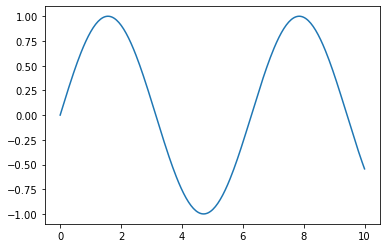

In [4]:
# Einfache Visualisierung der bisherigen Daten
plt.plot(ts_data.x_data,ts_data.y_true)

In [5]:
# Anzahl der Schritte in der Charge (auch für Prognoseschritte in die Zukunft eingesetzt)
num_time_steps = 30

In [6]:
# jetzt wir nur ein Teil dargestellt, das sind Zufallswerte
y1,y2,ts = ts_data.next_batch(1,num_time_steps,True)

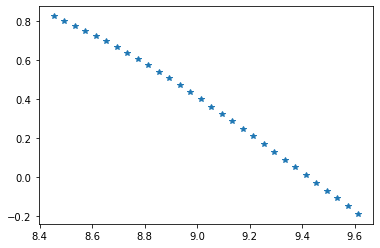

In [7]:
plt.plot(ts.flatten()[1:],y2.flatten(),'*')

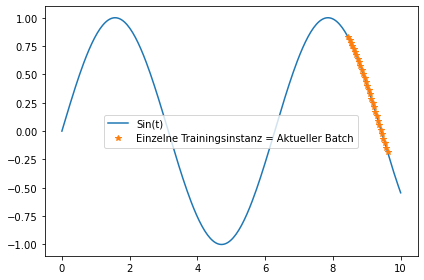

In [8]:
# einzeichnen des Batches und der zugehörigen in dem Gesamtkontext
plt.plot(ts_data.x_data,ts_data.y_true,label='Sin(t)')
plt.plot(ts.flatten()[1:],y2.flatten(),'*',label='Einzelne Trainingsinstanz = Aktueller Batch')
plt.legend()
plt.tight_layout()

### Eine Trainingsinstanz und was vorherzusagen ist

Wir versuchen, eine Zeitreihe vorherzusagen, die sich um t+1 verschoben hat.

In [9]:
train_inst = np.linspace(5,5 + ts_data.resolution * (num_time_steps + 1), num_time_steps+1)
train_inst

array([5.        , 5.04133333, 5.08266667, 5.124     , 5.16533333,
       5.20666667, 5.248     , 5.28933333, 5.33066667, 5.372     ,
       5.41333333, 5.45466667, 5.496     , 5.53733333, 5.57866667,
       5.62      , 5.66133333, 5.70266667, 5.744     , 5.78533333,
       5.82666667, 5.868     , 5.90933333, 5.95066667, 5.992     ,
       6.03333333, 6.07466667, 6.116     , 6.15733333, 6.19866667,
       6.24      ])

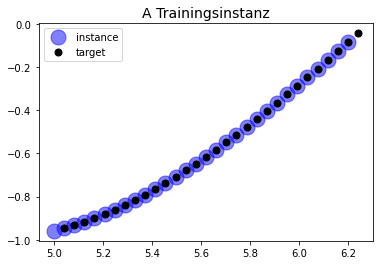

In [10]:
plt.title("A Trainingsinstanz", fontsize=14)
plt.plot(train_inst[:-1], ts_data.ret_true(train_inst[:-1]), "bo", markersize=15,alpha=0.5 ,label="instance")
plt.plot(train_inst[1:], ts_data.ret_true(train_inst[1:]), "ko", markersize=7, label="target")
plt.legend()

___________

# Das Modell erstellen

In [11]:
tf.reset_default_graph()

### Konstanten

In [12]:
# Nur ein Feature, die Zeitreihe
num_inputs = 1
# 100 Neuronenschicht, spiele mit dieser rum
num_neurons = 100
# Nur ein Output, vorhergesagte Zeitreihe
num_outputs = 1
# Lernrate, 0.0001 Standard, aber du kannst damit spielen.
learning_rate = 0.0001
# Wieviele Iterationen du durchlaufen lassen musst (Trainingsschritte), 
# du kannst auch mit dieser rumspielen.
num_train_iterations = 2000
# Größe der Batch
batch_size = 1

### Platzhalter

In [13]:
X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

____
____
### RNN Zellen Layer

Spiele mit den verschiedenen Zellen in diesem Abschnitt herum, vergleiche wie sie sich gegeneinander verhalten.

In [14]:
# Recurrent NN
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=num_neurons, activation=tf.nn.relu),
    output_size=num_outputs)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.


In [15]:
# cell = tf.contrib.rnn.OutputProjectionWrapper(
#     tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons, activation=tf.nn.relu),
#     output_size=num_outputs)

In [16]:
# n_neurons = 100
# n_layers = 3

# cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
#           for layer in range(n_layers)])

In [17]:
# cell = tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons, activation=tf.nn.relu)

In [18]:
# n_neurons = 100
# n_layers = 3

# cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)
#           for layer in range(n_layers)])

_____
_____

### Dynamische RNN Zelle

In [19]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


### Verlustfunktion und Optimierer

In [20]:
loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

#### Init Variablen

In [21]:
init = tf.global_variables_initializer()

## Session

In [22]:
# NUR FÜR GPU USER:
# https://stackoverflow.com/questions/34199233/how-to-prevent-tensorflow-from-allocating-the-totality-of-a-gpu-memory
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.85)

In [23]:
saver = tf.train.Saver()

In [24]:
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        
        # X-Werte und Y Werte von Batch
        X_batch, y_batch = ts_data.next_batch(batch_size, num_time_steps)
        #
        sess.run(train, feed_dict={X: X_batch, y: y_batch})
        
        # jeden Hundersten Wert zurück
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    # Save Model for Later
    saver.save(sess, "./rnn_time_series_model_prog")

0 	MSE: 0.36796287
100 	MSE: 0.21370156
200 	MSE: 0.026308963
300 	MSE: 0.043157864
400 	MSE: 0.062048484
500 	MSE: 0.0046548727
600 	MSE: 0.019608647
700 	MSE: 0.013394143
800 	MSE: 0.0036242441
900 	MSE: 0.027704516
1000 	MSE: 0.016338974
1100 	MSE: 0.0133646075
1200 	MSE: 0.014878454
1300 	MSE: 0.016885225
1400 	MSE: 0.0019415804
1500 	MSE: 0.0061731744
1600 	MSE: 0.012655075
1700 	MSE: 0.011025761
1800 	MSE: 0.0026294366
1900 	MSE: 0.015279742


### Vorhersage einer Zeitreihe t+1

In [28]:
with tf.Session() as sess:                          
    saver.restore(sess, "./rnn_time_series_model")   

    X_new = np.sin(np.array(train_inst[:-1].reshape(-1, num_time_steps, num_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


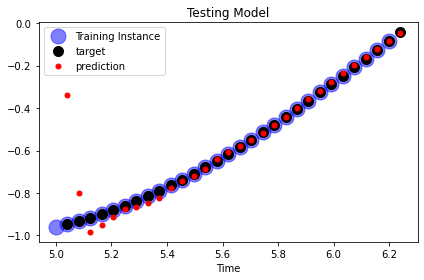

In [29]:
plt.title("Testing Model")

# Training Instanz
plt.plot(train_inst[:-1], np.sin(train_inst[:-1]), "bo", markersize=15,alpha=0.5, label="Training Instance")

# Ziel der Prognose
plt.plot(train_inst[1:], np.sin(train_inst[1:]), "ko", markersize=10, label="target")

# Modelle Vorhersage
plt.plot(train_inst[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")

plt.xlabel("Time")
plt.legend()
plt.tight_layout()

# Neue Sequenzen generieren
** Notiz: Die Vorhersage mit dem Modell kann manchmal verrückte Ergebnisse liefern, wie zum Beispiel exponentielles Wachstum.**

In [34]:
with tf.Session() as sess:
    saver.restore(sess, "./rnn_time_series_model")

    # SEED MIT NULLEN
    zero_seq_seed = [0. for i in range(num_time_steps)]
    for iteration in range(len(ts_data.x_data) - num_time_steps):
        X_batch = np.array(zero_seq_seed[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        zero_seq_seed.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


Text(0, 0.5, 'Value')

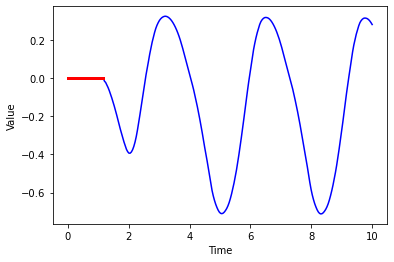

In [35]:
plt.plot(ts_data.x_data, zero_seq_seed, "b-")
plt.plot(ts_data.x_data[:num_time_steps], zero_seq_seed[:num_time_steps], "r", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")

In [36]:
with tf.Session() as sess:
    saver.restore(sess, "./rnn_time_series_model")# öffnen des 

    # SEED MIT Trainingsinstanz
    training_instance = list(ts_data.y_true[:30])
    for iteration in range(len(ts_data.x_data)-num_time_steps):
        X_batch = np.array(training_instance[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        training_instance.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


Text(0.5, 0, 'Time')

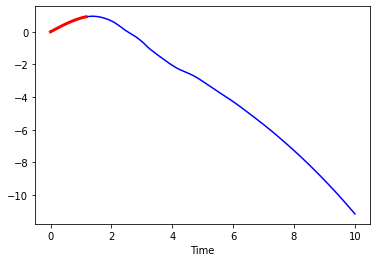

In [37]:
plt.plot(ts_data.x_data, training_instance, "b-")
plt.plot(ts_data.x_data[:num_time_steps],training_instance[:num_time_steps], "r-", linewidth=3)
plt.xlabel("Time")

# Gut gemacht!